In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import uproot
import ROOT
import pandas as pd
import awkward as ak
from analysis_samples import ttbar_sample, zhf_sample, jzw_sample, signal_samples, background_samples, expanded_background_samples, all_samples, data_sample
from bbtautau_helpers import Selection, BranchCut, eff_sens_plots, corr_plot, pairwise_corr_efficiencies, resolved_selection as resolved_selection_func, higg4d2_selection
from nn_helpers import AdHocData, NeuralNetworkV0, NeuralNetworkV1, NeuralNetworkV2, pred_tensor, populate_nn_results, collapse_model_branch, load_trained_branches
from branch_names import BranchNames
import torch
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, poisson
import warnings
import math
import importlib
import joblib
warnings.filterwarnings("ignore")

Welcome to JupyROOT 6.26/08


/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/awkward0/persist.py:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  {"minsize": 8192, "types": [numpy.bool_, numpy.bool, numpy.integer

Information not supplied to calculate MC weight
Information not supplied to calculate MC weight


In [3]:
branch_names = BranchNames()
branch_names.id_branch_name = ['EventNum']
branch_names.extra_branch_names = ['EventNum', 'IsElectron']

scaler = joblib.load('../trained_models/all_trained_dnn_v0_scaler.gz')

models = {}

models['V2Odd'] = NeuralNetworkV2(branch_names)
models['V2Odd'].load_state_dict(torch.load('../trained_models/all_trained_dnn_v2odd', map_location=torch.device('cpu')))
models['V2Odd'].eval()

models['V2Even'] = NeuralNetworkV2(branch_names)
models['V2Even'].load_state_dict(torch.load('../trained_models/all_trained_dnn_v2even', map_location=torch.device('cpu')))
models['V2Even'].eval()

NeuralNetworkV2(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=19, out_features=38, bias=True)
    (1): ReLU()
    (2): Linear(in_features=38, out_features=57, bias=True)
    (3): ReLU()
    (4): Linear(in_features=57, out_features=57, bias=True)
    (5): ReLU()
    (6): Linear(in_features=57, out_features=57, bias=True)
    (7): ReLU()
    (8): Linear(in_features=57, out_features=57, bias=True)
    (9): Dropout(p=0.2, inplace=False)
    (10): ReLU()
    (11): Linear(in_features=57, out_features=38, bias=True)
    (12): ReLU()
    (13): Linear(in_features=38, out_features=1, bias=True)
  )
)

In [3]:
load_branches = ['NNPredV2Fold', 'DiHiggsMV2Fold', 'HbbDiscV2Fold']
for sample in list(all_samples):
    load_trained_branches(sample, load_branches) 

In [4]:
boosted_selection = Selection()
nn_cut = BranchCut('NNPredV2Fold', 0.96, 'min')
m_cut = BranchCut('DiHiggsMV2Fold', 1000, 'min')
hbb_cut = BranchCut('HbbDiscV2Fold', 4, 'min')
boosted_selection.add_cut('NN', nn_cut)
boosted_selection.add_cut('Mass', m_cut)
boosted_selection.add_cut('Hbb', hbb_cut)

resolved_selection = resolved_selection_func()
h4d2_selection = higg4d2_selection()        

### HH->bbtautau BR

In [5]:
tau_to_lep_br = 0.35
tau_to_had_br = 1 - tau_to_lep_br
ditau_to_lephad_br = 2 * tau_to_lep_br * tau_to_had_br
h_to_bb_br = 0.58
h_to_tautau_br = 0.062
hh_to_bbtautau_br = 2 * h_to_bb_br * h_to_tautau_br * ditau_to_lephad_br
print(f'HH to bbtautau BR: {hh_to_bbtautau_br*100:.2f}%')

HH to bbtautau BR: 3.27%


# Boosted

### Background events in signal region

In [8]:
dihiggsm_cut = 1000
nn_cut = 0.96
hbb_cut = 4
nn_branch = 'NNPredV2Fold'

pair_selection = Selection()
pair_selection.set_cut('DiHiggsMV2Fold', dihiggsm_cut, 'min')
pair_selection.set_cut(nn_branch, nn_cut, 'min')

nn_selection = Selection()
nn_selection.set_cut(nn_branch, nn_cut, 'min')

m_selection = Selection()
m_selection.set_cut('DiHiggsMV2Fold', dihiggsm_cut, 'min')

hbb_selection = Selection()
hbb_selection.set_cut('HbbDiscV2Fold', hbb_cut, 'min')

background_nevents = 0
for sample in expanded_background_samples:
    print(sample.short_name)
    branches = sample.branches
    pair_eff = pair_selection.cuts_eff(branches)
    hbb_eff = hbb_selection.cuts_eff(branches)
    unw_nevents = pair_eff * hbb_eff * len(branches)
    nevents = unw_nevents * sample.mc_weight
    #print(f'{nevents:.2f}')
    background_nevents += nevents
    print(nevents)
    
print()
print(f'Total background events: {background_nevents:.4f} +/- {math.sqrt(background_nevents):.2f}')
print()

ttbar
16.31326266605507
Z+jets
0.006097189547844705
W+jets_taunu
0.0
W+jets_enu
0.03330588181760575
W+jets_munu
0.07543383632999999
JZ3W
0.0
JZ4W
10.742099674448694
JZ5W
0.4361977002918042
JZ6W
0.0011469089693129772

Total background events: 27.6075 +/- 5.25



### ABCD method

In [6]:
ave_events = 11.47
error = 0.72

low1_events = ave_events - error
low2_events = ave_events - 2*error
up1_events = ave_events + error
up2_events = ave_events + 2*error
print(f'Events: {ave_events:.2f} +/- {error:.2f}')
print(f'1 sigma lower bound events: {low1_events:.2f}')
print(f'2 sigma lower bound events: {low2_events:.2f}')
print(f'1 sigma upper bound events: {up1_events:.2f}')
print(f'2 sigma upper bound events: {up2_events:.2f}')

Events: 11.47 +/- 0.72
1 sigma lower bound events: 10.75
2 sigma lower bound events: 10.03
1 sigma upper bound events: 12.19
2 sigma upper bound events: 12.91


In [7]:
print(poisson.cdf(k=17, mu=11.47))

0.9551625083163674


In [8]:
thresholds = []
mus = [low2_events, low1_events, ave_events, up1_events, up2_events]
for events in mus:
    ci = 0
    i = 0
    while abs(ci) < 0.95:
        i += 1
        ci = poisson.cdf(k=i, mu=events)
    thresh_value = i
    print()
    print(f'Probability of {i} or fewer events for mean {events}: {ci*100:.2f}%')
    print()
    thresholds.append(thresh_value)
print(thresholds)


Probability of 15 or fewer events for mean 10.030000000000001: 95.02%


Probability of 16 or fewer events for mean 10.75: 95.27%


Probability of 17 or fewer events for mean 11.47: 95.52%


Probability of 18 or fewer events for mean 12.190000000000001: 95.75%


Probability of 19 or fewer events for mean 12.91: 95.97%

[15, 16, 17, 18, 19]


In [9]:
luminosity = 139

sample_limits = {}
for sample in signal_samples:
    print(sample.short_name)
    branches = sample.branches
        
#     pair_obs_eff = pair_selection.cuts_eff(branches)
#     hbb_eff = hbb_selection.cuts_eff(branches)
#     selection_eff = pair_obs_eff * hbb_eff
    selection_eff = boosted_selection.cuts_eff(branches)
    derivation_eff = len(branches) / sample.source_events
    eff = selection_eff * derivation_eff
    print(eff)
    
    sample_limits[sample.short_name] = []
    for threshold, mu in zip(thresholds, mus):
        excess_count = threshold - mu
        total_events = excess_count / eff
        bbtautau_lephad_limit = total_events / luminosity
        hh_limit = bbtautau_lephad_limit / hh_to_bbtautau_br
        sample_limits[sample.short_name].append(hh_limit)
        print(f'{hh_limit:.2f}')
        print()  

1 TeV
0.00022999999999999998
4750.65

5018.29

5285.93

5553.57

5821.21

1.6 TeV
0.0519076923076923
21.05

22.24

23.42

24.61

25.79

2 TeV
0.06536666666666667
16.72

17.66

18.60

19.54

20.48



In [10]:
print((18-12.19)/(17-11.47))
print(5553.57/5285.93)
print(24.61/23.42)
print(19.54/18.60)

1.0506329113924053
1.0506325282400637
1.0508112724167378
1.050537634408602


In [11]:
print(sample_limits)

{'1 TeV': [4750.646081175989, 5018.288113918299, 5285.930146660608, 5553.572179402916, 5821.214212145227], '1.6 TeV': [21.049839630581218, 22.235746088642138, 23.42165254670305, 24.607559004763964, 25.793465462824884], '2 TeV': [16.715684834326524, 17.65741355738718, 18.599142280447825, 19.540871003508475, 20.482599726569127]}


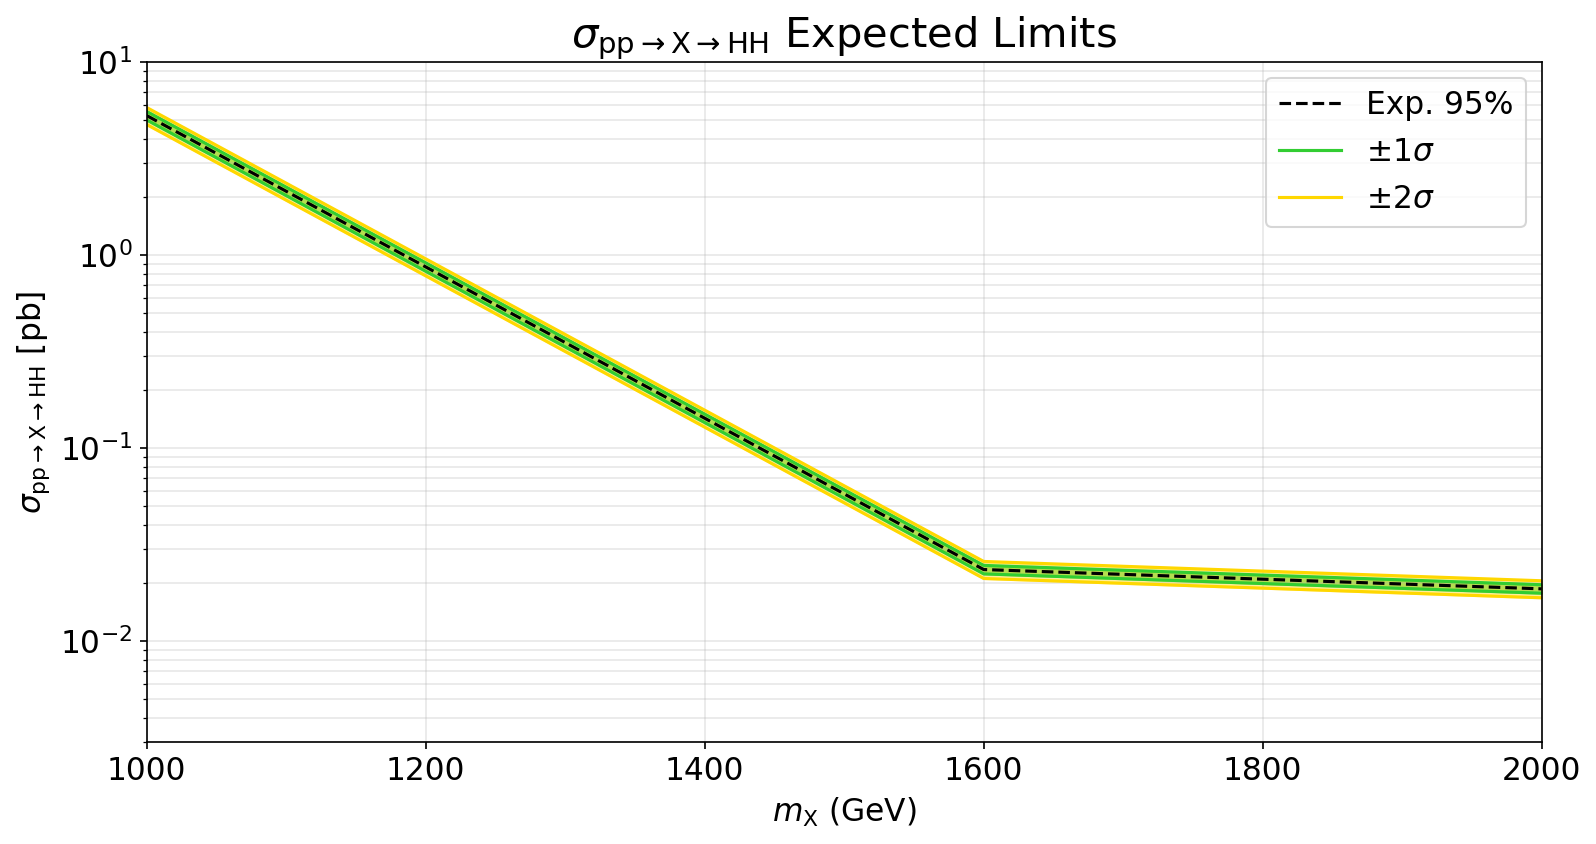

In [13]:
plt.rcParams['figure.figsize'] = [12,6] 
plt.rcParams['figure.dpi'] = 150

mass_wps = np.array([1000, 1600, 2000])
lower2_bounds = np.array([sample_bounds[0] for sample_bounds in sample_limits.values()]) * 1e-3
lower1_bounds = np.array([sample_bounds[1] for sample_bounds in sample_limits.values()]) * 1e-3
limits = np.array([sample_bounds[2] for sample_bounds in sample_limits.values()]) * 1e-3
upper1_bounds = np.array([sample_bounds[3] for sample_bounds in sample_limits.values()]) * 1e-3
upper2_bounds = np.array([sample_bounds[4] for sample_bounds in sample_limits.values()]) * 1e-3
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.plot(mass_wps, limits, color='black', linestyle='--', label='Exp. 95%')
plt.plot(mass_wps, lower1_bounds, color='limegreen', label='$\pm 1\sigma$')
plt.plot(mass_wps, upper1_bounds, color='limegreen')
plt.plot(mass_wps, lower2_bounds, color='gold', label='$\pm 2\sigma$')
plt.plot(mass_wps, upper2_bounds, color='gold')
plt.fill_between(mass_wps, lower1_bounds, upper1_bounds, color='limegreen', alpha=0.6)
plt.fill_between(mass_wps, lower2_bounds, upper2_bounds, color='gold', alpha=0.4)
plt.ylim(.003, 10)
plt.xlim(1000, 2000)
plt.yscale('log')
plt.grid(1, which='both', alpha=0.3)
plt.ylabel(r'$\sigma_\mathrm{pp \rightarrow X \rightarrow HH}$ [pb]', fontsize=15)
plt.xlabel(r'$m_\mathrm{X}$ (GeV)', fontsize=15)
plt.title(r'$\sigma_\mathrm{pp \rightarrow X \rightarrow HH}$ Expected Limits', fontsize=20)
plt.legend(fontsize=15)
plt.show()

In [18]:
print(sample_limits)

{'1 TeV': [4611.283688856002, 3378.088924711116, 5844.478453000888], '1.6 TeV': [34.782334783178186, 25.480501273561444, 44.08416829279494], '2 TeV': [21.4846611090923, 15.739022068668636, 27.230300149515962]}


# Resolved

In [14]:
resolved_selection = resolved_selection_func()

In [15]:
background_nevents = resolved_selection.nevents_passing_cuts(ttbar_sample.branches)

ci = 0
i = background_nevents
while abs(ci) < 0.95:
    i += 1
    ci = poisson.cdf(k=i, mu=background_nevents)
thresh_value = i
print()
print(f'Probability of {i} or fewer events: {ci*100:.2f}%')
print()
thresholds = [thresh_value]


Probability of 162 or fewer events: 95.50%



In [16]:
luminosity = 139

sample_limits = {}
for sample in signal_samples:
    print(sample.short_name)
    branches = sample.branches
        
    selection_eff = resolved_selection.cuts_eff(branches)
    derivation_eff = len(branches) / sample.source_events
    eff = selection_eff * derivation_eff
    print(eff)
    
    sample_limits[sample.short_name] = []
    for threshold in thresholds:
        excess_count = threshold - background_nevents
        total_events = excess_count / eff
        bbtautau_lephad_limit = total_events / luminosity
        hh_limit = bbtautau_lephad_limit / hh_to_bbtautau_br
        sample_limits[sample.short_name].append(hh_limit)
        print(f'{hh_limit:.2f}')
        print()  

1 TeV
0.03688
119.22

1.6 TeV
0.014561538461538459
301.96

2 TeV
0.00645
681.70



In [17]:
mass_wps = np.array([1000, 1600, 2000])
limits = np.array([sample_bounds[0] for sample_bounds in sample_limits.values()]) * 1e-3
print(sample_limits)
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.plot(mass_wps, limits)
plt.ylim(.003, 10)
plt.xlim(1000, 2500)
plt.yscale('log')
plt.grid(1, which='both', alpha=0.3)
plt.ylabel(r'$\sigma_\mathrm{pp \rightarrow X \rightarrow HH}$ [pb]', fontsize=15)
plt.xlabel(r'$m_\mathrm{X}$ (GeV)', fontsize=15)
plt.title(r'$\sigma_\mathrm{pp \rightarrow X \rightarrow HH}$ Expected Limits (Resolved Approx.)', fontsize=20)
plt.legend(fontsize=15)
plt.show()

No handles with labels found to put in legend.


{'1 TeV': [119.22386800962799], '1.6 TeV': [301.9582212283997], '2 TeV': [681.7017445263691]}
